In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Tow-Mater-Labs/test.csv
/kaggle/input/Tow-Mater-Labs/sample.csv
/kaggle/input/Tow-Mater-Labs/train.csv


# Importing Libraries

In [2]:
# For mathematical and statistical computations
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import math
from math import ceil, floor, log
import random
sns.set(style='whitegrid')
%matplotlib inline 

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

## Reading Training and Testing data

In [3]:
train = pd.read_csv('../input/Tow-Mater-Labs/train.csv')
test = pd.read_csv('../input/Tow-Mater-Labs/test.csv')

In [4]:
train.head()

,id,blood_group,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,mother_age,father_age,accepted
0,223723,O,Female,23,1,18.0,1,< 1 Year,No,29223.0,152.0,89,70,65,0
1,102674,AB-,Male,44,1,23.0,0,1-2 Year,Yes,28501.0,26.0,111,61,66,1
2,15567,AB+,Male,23,1,41.0,0,< 1 Year,Yes,32590.0,152.0,71,67,78,0
3,222937,O,Male,78,1,15.0,1,1-2 Year,No,2630.0,14.0,245,74,63,0
4,32565,B+,Female,25,1,44.0,1,< 1 Year,No,31821.0,152.0,59,73,62,0


In [5]:
test.head()

,id,blood_group,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,mother_age,father_age
0,485035,B+,Female,21,1,8.0,0,1-2 Year,Yes,43500.0,157.0,266,64,62
1,278306,O,Male,53,1,2.0,0,1-2 Year,Yes,33547.0,26.0,119,76,79
2,478061,AB+,Female,23,1,30.0,1,< 1 Year,No,41650.0,152.0,84,61,77
3,109822,AB-,Female,46,1,28.0,0,1-2 Year,Yes,39209.0,37.0,299,70,70
4,272343,AB-,Female,30,1,28.0,0,1-2 Year,Yes,43252.0,26.0,215,73,62


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266776 entries, 0 to 266775
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    266776 non-null  int64  
 1   blood_group           266776 non-null  object 
 2   Gender                266776 non-null  object 
 3   Age                   266776 non-null  int64  
 4   Driving_License       266776 non-null  int64  
 5   Region_Code           266776 non-null  float64
 6   Previously_Insured    266776 non-null  int64  
 7   Vehicle_Age           266776 non-null  object 
 8   Vehicle_Damage        266776 non-null  object 
 9   Annual_Premium        266776 non-null  float64
 10  Policy_Sales_Channel  266776 non-null  float64
 11  Vintage               266776 non-null  int64  
 12  mother_age            266776 non-null  int64  
 13  father_age            266776 non-null  int64  
 14  accepted              266776 non-null  int64  
dtype

In [7]:
train.accepted.value_counts()

0    234079
1     32697
Name: accepted, dtype: int64

In [8]:
numerical_columns=['Age', 'Region_Code','Annual_Premium','Vintage']
categorical_columns=['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage','accepted','blood_group']

In [9]:
train[numerical_columns].describe()

,Age,Region_Code,Annual_Premium,Vintage
count,266776.000000,266776.000000,266776.000000,266776.000000
mean,38.852311,26.400156,30551.832335,154.321693
std,15.517222,13.227109,17194.660980,83.732094
min,20.000000,0.000000,2630.000000,10.000000
25%,25.000000,15.000000,24406.000000,82.000000
50%,36.000000,28.000000,31656.000000,154.000000
75%,49.000000,35.000000,39377.000000,227.000000
max,85.000000,52.000000,540165.000000,299.000000


## Data Analysis using Graphs and value counts

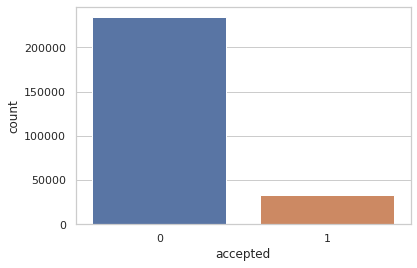

In [10]:
sns.countplot(train.accepted)

This shows that data is imbalanced(too many 0's and very few 1's) so we need to oversample or undersample data to try making it balanced

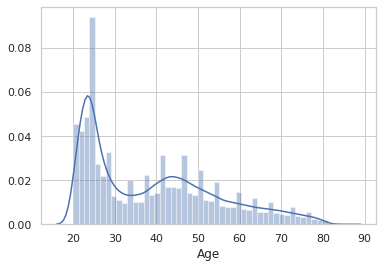

In [11]:
sns.distplot(train.Age)

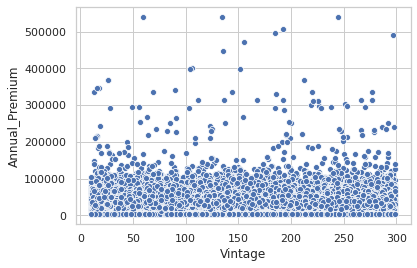

In [12]:
sns.scatterplot(x=train['Vintage'],y=train['Annual_Premium'])

Too many outliers in Annual Premium(can also be seen when we describe train data)

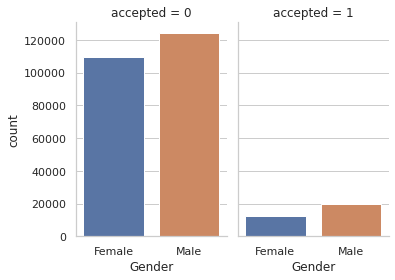

In [13]:
df=train.groupby(['Gender','accepted'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

g = sns.catplot(x="Gender", y="count",col="accepted",
                data=df, kind="bar",
                height=4, aspect=.7);

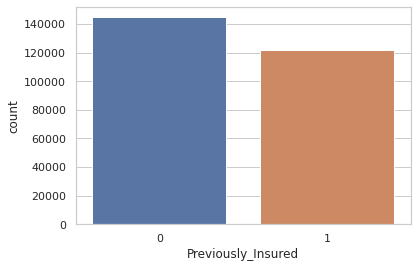

In [14]:
sns.countplot(train.Previously_Insured)

In [15]:
df=train.groupby(['Vehicle_Age','accepted'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
df

,Vehicle_Age,accepted,count
0,1-2 Year,0,116097
1,1-2 Year,1,24392
2,< 1 Year,0,110091
3,< 1 Year,1,4998
4,> 2 Years,0,7891
5,> 2 Years,1,3307


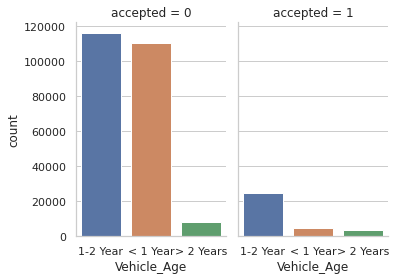

In [16]:
g = sns.catplot(x="Vehicle_Age", y="count",col="accepted",
                data=df, kind="bar",
                height=4, aspect=.7)

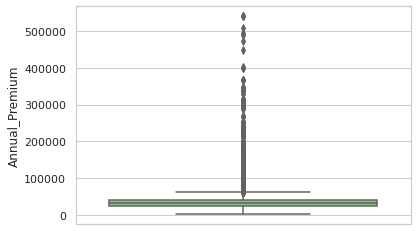

In [17]:
sns.boxplot(y = 'Annual_Premium', data = train,palette='Accent')

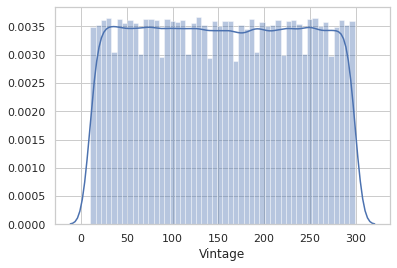

In [18]:
sns.distplot(train.Vintage)

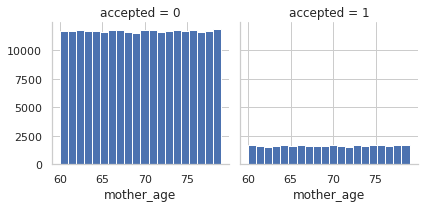

In [19]:
g=sns.FacetGrid(train,col='accepted')
g.map(plt.hist,'mother_age',bins=20)

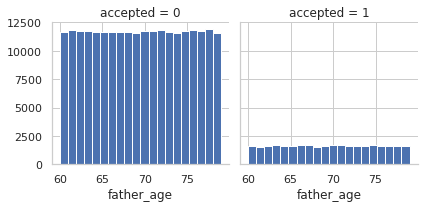

In [20]:
g=sns.FacetGrid(train,col='accepted')
g.map(plt.hist,'father_age',bins=20)

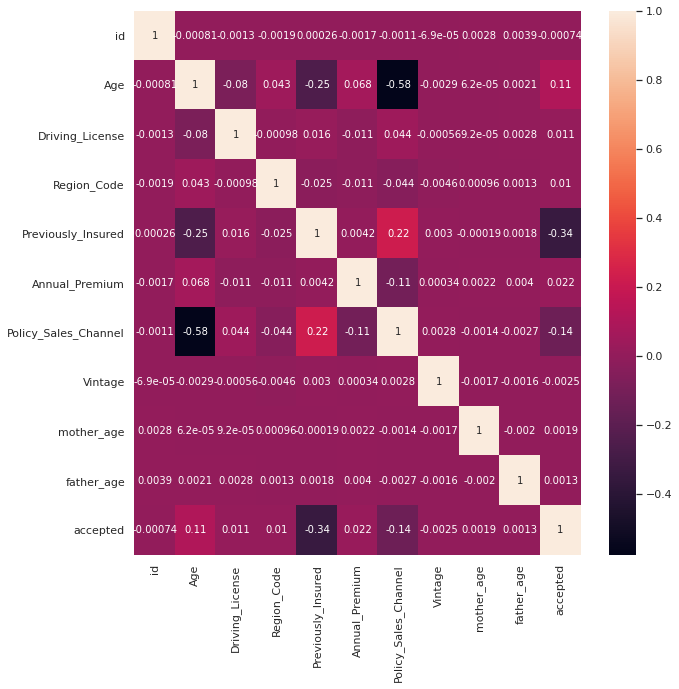

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),annot=True)
plt.show()

In [ ]:
# Upsampling function to balance data 
def upsample(df, u_feature, n_upsampling):
    ones = df.copy()
    for n in range(n_upsampling):
        if u_feature == 'Annual_Premium':
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-1,1)* x *0.05) # change Annual_premiun in the range of 5%
        else:
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-5,5)) # change Age in the range of 5 years
                
        if n == 0:
            df_new = df.copy()
        else:
            df_new = pd.concat([df_new, df])
    return df_new

In [22]:
num_feat = ['Age','Vintage']
cat_feat = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age_lt_1_Year','Vehicle_Age_gt_2_Years','Vehicle_Damage_Yes','Region_Code','Policy_Sales_Channel','blood_group']

## Label Encoding of Categorical data

In [23]:
train['Gender'] = train['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
train['blood_group'] = train['blood_group'].map( {'B+':1,'O':2,'AB+':3,'AB-':4} ).astype(int)

In [24]:
train=pd.get_dummies(train,drop_first=True)

In [25]:
train=train.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
train['Vehicle_Age_lt_1_Year']=train['Vehicle_Age_lt_1_Year'].astype('int')
train['Vehicle_Age_gt_2_Years']=train['Vehicle_Age_gt_2_Years'].astype('int')
train['Vehicle_Damage_Yes']=train['Vehicle_Damage_Yes'].astype('int')

In [26]:
train

,id,blood_group,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,mother_age,father_age,accepted,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes
0,223723,2,0,23,1,18.0,1,29223.0,152.0,89,70,65,0,1,0,0
1,102674,4,1,44,1,23.0,0,28501.0,26.0,111,61,66,1,0,0,1
2,15567,3,1,23,1,41.0,0,32590.0,152.0,71,67,78,0,1,0,1
3,222937,2,1,78,1,15.0,1,2630.0,14.0,245,74,63,0,0,0,0
4,32565,1,0,25,1,44.0,1,31821.0,152.0,59,73,62,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266771,349992,2,1,24,1,28.0,1,49840.0,152.0,39,72,74,0,1,0,0
266772,260914,3,1,41,1,14.0,0,31399.0,26.0,25,63,75,0,0,0,1
266773,214966,3,1,44,1,3.0,0,21292.0,26.0,36,73,70,0,0,0,1
266774,200722,1,1,38,1,30.0,1,29448.0,26.0,117,62,76,0,0,0,1


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266776 entries, 0 to 266775
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      266776 non-null  int64  
 1   blood_group             266776 non-null  int64  
 2   Gender                  266776 non-null  int64  
 3   Age                     266776 non-null  int64  
 4   Driving_License         266776 non-null  int64  
 5   Region_Code             266776 non-null  float64
 6   Previously_Insured      266776 non-null  int64  
 7   Annual_Premium          266776 non-null  float64
 8   Policy_Sales_Channel    266776 non-null  float64
 9   Vintage                 266776 non-null  int64  
 10  mother_age              266776 non-null  int64  
 11  father_age              266776 non-null  int64  
 12  accepted                266776 non-null  int64  
 13  Vehicle_Age_lt_1_Year   266776 non-null  int64  
 14  Vehicle_Age_gt_2_Yea

### Droping unimportant features from Corr matrix

In [28]:
train=train.drop(['id','mother_age','father_age','Annual_Premium'],axis=1)

## Scaling data for better model predictions

In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
ss = StandardScaler()
train = ss.fit_transform(train)


# mm = MinMaxScaler()
# # train[['Annual_Premium']] = mm.fit_transform(train[['Annual_Premium']])

In [30]:
for column in cat_feat:
    train[column] = train[column].astype('int')

In [31]:
train

,blood_group,Gender,Age,Driving_License,Region_Code,Previously_Insured,Policy_Sales_Channel,Vintage,accepted,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes
0,2,0,-1.021597,1,18,1,152,-0.780129,0,1,0,0
1,4,1,0.331741,1,23,0,26,-0.517386,1,0,0,1
2,3,1,-1.021597,1,41,0,152,-0.995101,0,1,0,1
3,2,1,2.522859,1,15,1,14,1.082960,0,0,0,0
4,1,0,-0.892707,1,44,1,152,-1.138415,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
266771,2,1,-0.957152,1,28,1,152,-1.377272,0,1,0,0
266772,3,1,0.138407,1,14,0,26,-1.544473,0,0,0,1
266773,3,1,0.331741,1,3,0,26,-1.413101,0,0,0,1
266774,1,1,-0.054927,1,30,1,26,-0.445728,0,0,0,1


In [32]:
test['Gender'] = test['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
test['blood_group'] = test['blood_group'].map( {'B+':1,'O':2,'AB+':3,'AB-':4} ).astype(int)


test=pd.get_dummies(test,drop_first=True)

test=test.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
test['Vehicle_Age_lt_1_Year']=test['Vehicle_Age_lt_1_Year'].astype('int')
test['Vehicle_Age_gt_2_Years']=test['Vehicle_Age_gt_2_Years'].astype('int')
test['Vehicle_Damage_Yes']=test['Vehicle_Damage_Yes'].astype('int')

In [33]:
test_id=test.id
test=test.drop(['id','mother_age','father_age','Annual_Premium'],axis=1)

In [34]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
ss = StandardScaler()
test = ss.fit_transform(test)


mm = MinMaxScaler()
# test[['Annual_Premium']] = mm.fit_transform(test[['Annual_Premium']])

In [35]:
for column in cat_feat:
    test[column] = test[column].astype('int')

In [36]:
from sklearn.model_selection import train_test_split

train_target=train['accepted']
train_1=train.drop(['accepted'], axis = 1)
x_train,x_test, _,y_test = train_test_split(train,train_target, random_state = 0,train_size=0.8)
x_test = x_test.drop(columns = ['accepted'])

## Upsampling/Oversampling data

In [39]:
df_train_up_a = upsample(x_train.loc[x_train['accepted'] == 1], 'Age', 1)
df_train_up_v = upsample(x_train.loc[x_train['accepted'] == 1], 'Policy_Sales_Channel', 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [40]:
X_train = pd.concat([train,df_train_up_a])
X_train = pd.concat([X_train,df_train_up_v])

In [41]:
x_train = X_train.drop(columns = ['accepted'])
y_train = X_train.accepted

In [42]:
y_train.value_counts()

0    234079
1     84949
Name: accepted, dtype: int64

In [43]:
x_train.columns

Index(['blood_group', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Policy_Sales_Channel', 'Vintage',
       'Vehicle_Age_lt_1_Year', 'Vehicle_Age_gt_2_Years',
       'Vehicle_Damage_Yes'],
      dtype='object')

 ## Model Preparation and Testing

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from scipy.stats import randint
import pickle
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score,accuracy_score,confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 

In [45]:
%matplotlib inline

In [46]:
x_train.dtypes

blood_group                 int64
Gender                      int64
Age                       float64
Driving_License             int64
Region_Code                 int64
Previously_Insured          int64
Policy_Sales_Channel        int64
Vintage                   float64
Vehicle_Age_lt_1_Year       int64
Vehicle_Age_gt_2_Years      int64
Vehicle_Damage_Yes          int64
dtype: object

## Using XGBoost classifier

In [47]:
xgc = xgb.XGBClassifier(n_estimators=1000,scale_pos_weight=7.1)
# xgc = xgb.XGBClassifier(max_depth = 8, 
#                             n_estimators = 30000, 
#                             reg_lambda = 1.2, reg_alpha = 1.2, 
#                             min_child_weight = 1, 
#                             objective = 'binary:logistic',
#                             learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')
xgc.fit(x_train,y_train,verbose = 100)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
from sklearn import metrics
preds=xgc.predict(x_test)
print(metrics.classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86     46785
           1       0.36      0.98      0.52      6571

    accuracy                           0.78     53356
   macro avg       0.68      0.87      0.69     53356
weighted avg       0.92      0.78      0.81     53356



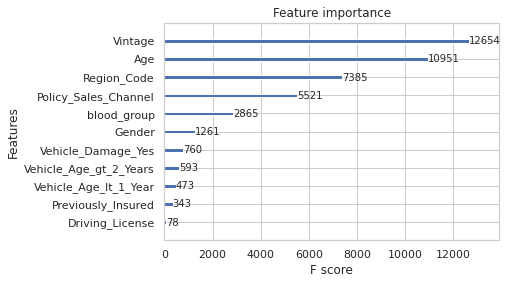

In [49]:
# xgb.plot_importance(xgb_model)
xgb.plot_importance(xgc)

## Test data Predictions and Submission

In [51]:
test.head()

,blood_group,Gender,Age,Driving_License,Region_Code,Previously_Insured,Policy_Sales_Channel,Vintage,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes
0,1,0,-1.145496,1,8,0,157,1.335971,0,0,1
1,2,1,0.919249,1,2,0,26,-0.423892,0,0,1
2,3,0,-1.016449,1,30,1,152,-0.842907,1,0,0
3,4,0,0.467586,1,28,0,37,1.731042,0,0,1
4,4,0,-0.564786,1,28,0,26,0.725406,0,0,1


In [52]:
# preds=xgc.predict(test)
# print(metrics.classification_report(test_.Response,test_.pred))

In [53]:
preds = xgc.predict(test)

In [54]:
preds

array([0, 1, 0, ..., 0, 1, 0])

In [55]:
submission = pd.DataFrame(data = {'id': test_id, 'accepted': preds})
submission.to_csv('Tow_mater_1.csv', index = False)
submission.head()

,id,accepted
0,485035,0
1,278306,1
2,478061,0
3,109822,1
4,272343,1
